In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import impute

In [3]:
#import the csv files
drugsHourly = pd.read_csv(r'C:\Users\ariki\OneDrive\שולחן העבודה\Drugs_Hourly_vaso_demo.csv', encoding = 'ISO-8859-1',)
# drugsHourly = pd.read_csv(r'Drugs_Hourly_vaso_demo.csv', encoding = 'ISO-8859-1',)
deadAlive = pd.read_csv(r'C:\Users\ariki\OneDrive\שולחן העבודה\ver12_proj3_outcomes_3-7_demo.csv', encoding = 'ISO-8859-1',)
# deadAlive = pd.read_csv(r'ver12_proj3_outcomes_3-7_demo.csv', encoding = 'ISO-8859-1',)

In [4]:
#merge the two table into one
merged_df = pd.merge(drugsHourly, deadAlive, on=['patient_id'], how='inner', indicator=True)
merged_df.drop(['_merge', 'Unnamed: 0'], axis=1, inplace=True)
merged_df.head()

,patient_id,hour_counter,Noradrenaline (Norepinephrine),Vasopressin=Argipressin,Adrenalin (Epinephrine),Dobutrex (Dobutamine),Dopamine,ICU_LOS,LOS_Group,ICU_mortality
0,002E7282-9C02-4D5C-8D3B-DDA2574ABCEF,0,0.0,0.0,0.0,0.0,0.0,5,LOS_5-7,0
1,002E7282-9C02-4D5C-8D3B-DDA2574ABCEF,1,0.0,0.0,0.0,0.0,0.0,5,LOS_5-7,0
2,002E7282-9C02-4D5C-8D3B-DDA2574ABCEF,2,0.0,0.0,0.0,0.0,0.0,5,LOS_5-7,0
3,002E7282-9C02-4D5C-8D3B-DDA2574ABCEF,3,0.0,0.0,0.0,0.0,0.0,5,LOS_5-7,0
4,002E7282-9C02-4D5C-8D3B-DDA2574ABCEF,4,0.0,0.0,0.0,0.0,0.0,5,LOS_5-7,0


In [5]:
#remove lines where hour_counter<0
merged_df = merged_df[merged_df.hour_counter>=0]
merged_df.head()

,patient_id,hour_counter,Noradrenaline (Norepinephrine),Vasopressin=Argipressin,Adrenalin (Epinephrine),Dobutrex (Dobutamine),Dopamine,ICU_LOS,LOS_Group,ICU_mortality
0,002E7282-9C02-4D5C-8D3B-DDA2574ABCEF,0,0.0,0.0,0.0,0.0,0.0,5,LOS_5-7,0
1,002E7282-9C02-4D5C-8D3B-DDA2574ABCEF,1,0.0,0.0,0.0,0.0,0.0,5,LOS_5-7,0
2,002E7282-9C02-4D5C-8D3B-DDA2574ABCEF,2,0.0,0.0,0.0,0.0,0.0,5,LOS_5-7,0
3,002E7282-9C02-4D5C-8D3B-DDA2574ABCEF,3,0.0,0.0,0.0,0.0,0.0,5,LOS_5-7,0
4,002E7282-9C02-4D5C-8D3B-DDA2574ABCEF,4,0.0,0.0,0.0,0.0,0.0,5,LOS_5-7,0


In [6]:
#remove all patients who didn't get Noradrenaline
allID = merged_df.patient_id.unique()
for i in allID:
    dfID = merged_df[merged_df.patient_id==i]
    noNor = dfID[dfID["Noradrenaline (Norepinephrine)"]==0]
    if(dfID.shape[0]==noNor.shape[0]):
        merged_df = merged_df[merged_df.patient_id!=i]
merged_df.head()

,patient_id,hour_counter,Noradrenaline (Norepinephrine),Vasopressin=Argipressin,Adrenalin (Epinephrine),Dobutrex (Dobutamine),Dopamine,ICU_LOS,LOS_Group,ICU_mortality
37,0090EDD0-704B-4AF4-B18D-90A06A5C6514,1,0.40037,0.0,0.0,0.0,0.0,6,LOS_5-7,0
38,0090EDD0-704B-4AF4-B18D-90A06A5C6514,2,0.37020,0.0,0.0,0.0,0.0,6,LOS_5-7,0
39,0090EDD0-704B-4AF4-B18D-90A06A5C6514,3,0.34560,0.0,0.0,0.0,0.0,6,LOS_5-7,0
40,0090EDD0-704B-4AF4-B18D-90A06A5C6514,4,0.29640,0.0,0.0,0.0,0.0,6,LOS_5-7,0
41,0090EDD0-704B-4AF4-B18D-90A06A5C6514,5,0.26196,0.0,0.0,0.0,0.0,6,LOS_5-7,0


In [7]:
#function to find diffrenes between alive and ead in given hour
def find_diffrence_per_hour (h):
    allAlive = merged_df[merged_df['ICU_mortality'] == 0]
    allAlive = allAlive[allAlive.hour_counter==h]
#     allAliveGotNor = allAlive[allAlive["Noradrenaline (Norepinephrine)"]>0]
    aliveMeanNor = allAlive["Noradrenaline (Norepinephrine)"].mean()
#     print(aliveMeanNor)
    
    allDead = merged_df[merged_df['ICU_mortality'] == 1]
    allDead = allDead[allDead.hour_counter==h]
    allDeadGotNor = allDead[allDead["Noradrenaline (Norepinephrine)"]>0]
    deadMeanNor = allDeadGotNor["Noradrenaline (Norepinephrine)"].mean()
#     print(deadMeanNor)
    
    cd=0
    cr = 0
    a = 0
    b = 0
    for index, row in allDeadGotNor.iterrows():
        if (row['Noradrenaline (Norepinephrine)']<deadMeanNor):
            cd=cd+1
            cr = cr + row['Noradrenaline (Norepinephrine)']
        else:
#             print(row['Noradrenaline (Norepinephrine)'] - deadMeanNor)
            b = b + 1
            a = a +row['Noradrenaline (Norepinephrine)']
    
    print("dead < dead  ", cr/cd , cd)
    print("dead > dead  " , a/b , b)
    
    

    ca=0
    cb = 0
    k = 0
    d = 0
    for index, row in allAlive.iterrows():
        if (row['Noradrenaline (Norepinephrine)']<deadMeanNor):
            ca=ca+1
            cb = cb + row['Noradrenaline (Norepinephrine)']
        else:
#             print(row['Noradrenaline (Norepinephrine)'] - deadMeanNor)
            d = d + 1
            k = k +row['Noradrenaline (Norepinephrine)']
    print("alive < dead  ", cb/ca , ca)
    print("alive > dead  ", k / d , d)
    
    print ("alive mean Nor ", aliveMeanNor, " dead mean Nor ", deadMeanNor, " \nless than mean of dead " ,ca, " alive ",
           len(allAlive) , " less than mean of dead ", cd, "dead", len(allDeadGotNor))
    print("yahas ", ca/len(allAlive), "     ", cd/len(allDeadGotNor))
    
for i in range(0, 70):
    print("###################################   ", i   , "######################################")
    find_diffrence_per_hour (i)

###################################    0 ######################################
dead < dead   0.3922291666666667 60
dead > dead   2.405315172413793 29
alive < dead   0.2977806008583694 233
alive > dead   1.6680797727272725 44
alive mean Nor  0.5154454512635381  dead mean Nor  1.0481785393258427  
less than mean of dead  233  alive  277  less than mean of dead  60 dead 89
yahas  0.8411552346570397       0.6741573033707865
###################################    1 ######################################
dead < dead   0.6353015277777776 72
dead > dead   2.7833505 40
alive < dead   0.4231435563380283 284
alive > dead   2.1060651999999997 50
alive mean Nor  0.6750779341317367  dead mean Nor  1.4024618750000009  
less than mean of dead  284  alive  334  less than mean of dead  72 dead 112
yahas  0.8502994011976048       0.6428571428571429
###################################    2 ######################################
dead < dead   0.7950840243902435 82
dead > dead   3.3283461111111112 36
alive

In [50]:
#function to find diffrenes between alive and ead in given hour
def find_diffrence_per_hour1 (h):
    allAlive = merged_df[merged_df['ICU_mortality'] == 0]
    allAlive = allAlive[allAlive.hour_counter==h]
#     allAliveGotNor = allAlive[allAlive["Noradrenaline (Norepinephrine)"]>0]
    aliveMeanNor = allAlive["Noradrenaline (Norepinephrine)"].mean()
#     print(aliveMeanNor)
    
    allDead = merged_df[merged_df['ICU_mortality'] == 1]
    allDead = allDead[allDead.hour_counter==h]
    allDeadGotNor = allDead[allDead["Noradrenaline (Norepinephrine)"]>0]
    deadMeanNor = allDeadGotNor["Noradrenaline (Norepinephrine)"].mean()
#     print(deadMeanNor)
    
    cd=0
    cr = 0
    a = 0
    b = 0
    for index, row in allDeadGotNor.iterrows():
        if (row['Noradrenaline (Norepinephrine)']<aliveMeanNor):
            cd=cd+1
            cr = cr + row['Noradrenaline (Norepinephrine)']
        else:
#             print(row['Noradrenaline (Norepinephrine)'] - deadMeanNor)
            b = b + 1
            a = a +row['Noradrenaline (Norepinephrine)']
    
    print("dead < alive  ", cr/cd , cd)
    print("dead > alive  " , a/b , b)
    
    

    ca=0
    cb = 0
    k = 0
    d = 0
    for index, row in allAlive.iterrows():
        if (row['Noradrenaline (Norepinephrine)']<aliveMeanNor):
            ca=ca+1
            cb = cb + row['Noradrenaline (Norepinephrine)']
        else:
#             print(row['Noradrenaline (Norepinephrine)'] - deadMeanNor)
            d = d + 1
            k = k +row['Noradrenaline (Norepinephrine)']
    print("alive < alive  ", cb/ca , ca)
    print("alive > alive  ", k / d , d)
    
    w=0
    x = 0
    y = 0
    z = 0
    for index, row in allDeadGotNor.iterrows():
        if (row['Noradrenaline (Norepinephrine)'] > cb/ca and row['Noradrenaline (Norepinephrine)'] < aliveMeanNor):
#             print(row['Noradrenaline (Norepinephrine)'])
            w=w+1
            x = x + row['Noradrenaline (Norepinephrine)']
        
    print("dead between alive  ", x/w , w)
#     print("dead not between alive  ", z/y , y)  
    print ("alive mean Nor ", aliveMeanNor, " dead mean Nor ", deadMeanNor, " \nless than mean of dead " ,ca, " alive ",
           len(allAlive) , " less than mean of dead ", cd, "dead", len(allDeadGotNor))
    print("yahas ", ca/len(allAlive), "     ", cd/len(allDeadGotNor))
    
for i in range(0, 73):
    print("###################################   ", i   , "######################################")
    find_diffrence_per_hour1 (i)

###################################    0 ######################################
dead < alive   0.24651357142857155 42
dead > alive   1.76456 47
alive < alive   0.15979482954545451 176
alive > alive   1.1351930693069308 101
dead between alive   0.3417150000000001 26
alive mean Nor  0.5154454512635381  dead mean Nor  1.0481785393258427  
less than mean of dead  176  alive  277  less than mean of dead  42 dead 89
yahas  0.6353790613718412       0.47191011235955055
###################################    1 ######################################
dead < alive   0.36357540540540545 37
dead > alive   1.9149792000000005 75
alive < alive   0.2358738349514564 206
alive > alive   1.3819220312500007 128
dead between alive   0.4635811111111112 27
alive mean Nor  0.6750779341317367  dead mean Nor  1.4024618750000009  
less than mean of dead  206  alive  334  less than mean of dead  37 dead 112
yahas  0.6167664670658682       0.33035714285714285
###################################    2 ################

In [112]:
#function to find diffrenes between alive and ead in given hour
def find_diffrence_per_hour2 (h, ICU, kind):
    if ICU ==0 and kind == 0:
        df = merged_df[merged_df['ICU_mortality'] == ICU]
        df = df[df.hour_counter==h]
    #     allAliveGotNor = allAlive[allAlive["Noradrenaline (Norepinephrine)"]>0]
        mean = df["Noradrenaline (Norepinephrine)"].mean()
    #     print(aliveMeanNor)
    if ICU == 1 and kind == 0:
        df = merged_df[merged_df['ICU_mortality'] == ICU]
        df = df[df.hour_counter==h]
        df = df[df["Noradrenaline (Norepinephrine)"]>0]
        mean = df["Noradrenaline (Norepinephrine)"].mean()
    #     print(deadMeanNor)
    if ICU ==0 and kind == 1:
        df = merged_df[merged_df['ICU_mortality'] == ICU]
        dn = merged_df[merged_df['ICU_mortality'] == 1]
        df = df[df.hour_counter==h]
    #     allAliveGotNor = allAlive[allAlive["Noradrenaline (Norepinephrine)"]>0]
        mean = dn["Noradrenaline (Norepinephrine)"].mean()
    #     print(aliveMeanNor)
    if ICU == 1 and kind == 1:
        df = merged_df[merged_df['ICU_mortality'] == ICU]
        dn = merged_df[merged_df['ICU_mortality'] == 0]
        df = df[df.hour_counter==h]
        df = df[df["Noradrenaline (Norepinephrine)"]>0]
        mean = dn["Noradrenaline (Norepinephrine)"].mean()
    #     print(deadMeanNor)
    
    cd=0
    cr = 0
    a = 0
    b = 0
    for index, row in df.iterrows():
        if (row['Noradrenaline (Norepinephrine)'] < mean):
            cd=cd+1
            cr = cr + row['Noradrenaline (Norepinephrine)']
    
    return cd
  
    
    
    
    
#function to find diffrenes between alive and ead in given hour
def find_diffrence_per_hour3 (h, ICU, kind):
    if ICU ==0 and kind == 0:
        df = merged_df[merged_df['ICU_mortality'] == ICU]
        df = df[df.hour_counter==h]
    #     allAliveGotNor = allAlive[allAlive["Noradrenaline (Norepinephrine)"]>0]
        mean = df["Noradrenaline (Norepinephrine)"].mean()
    #     print(aliveMeanNor)
    if ICU == 1 and kind == 0:
        df = merged_df[merged_df['ICU_mortality'] == ICU]
        df = df[df.hour_counter==h]
        df = df[df["Noradrenaline (Norepinephrine)"]>0]
        mean = df["Noradrenaline (Norepinephrine)"].mean()
    #     print(deadMeanNor)
    if ICU ==0 and kind == 1:
        df = merged_df[merged_df['ICU_mortality'] == ICU]
        dn = merged_df[merged_df['ICU_mortality'] == 1]
        df = df[df.hour_counter==h]
    #     allAliveGotNor = allAlive[allAlive["Noradrenaline (Norepinephrine)"]>0]
        mean = dn["Noradrenaline (Norepinephrine)"].mean()
    #     print(aliveMeanNor)
    if ICU == 1 and kind == 1:
        df = merged_df[merged_df['ICU_mortality'] == ICU]
        dn = merged_df[merged_df['ICU_mortality'] == 0]
        df = df[df.hour_counter==h]
        df = df[df["Noradrenaline (Norepinephrine)"]>0]
        mean = dn["Noradrenaline (Norepinephrine)"].mean()
    #     print(deadMeanNor)
    
    cd=0
    cr = 0
    a = 0
    b = 0
    for index, row in df.iterrows():
        if (row['Noradrenaline (Norepinephrine)'] > mean):
            cd=cd+1
            cr = cr + row['Noradrenaline (Norepinephrine)']
    
    return cd   

In [113]:
data = []
data1 = []
data2 = []
data3 = []
data4 = []
data5 = []
data6 = []
data7 = []
for i in range(0, 72):
    data.append(find_diffrence_per_hour2 (i, 1, 0))
    data1.append(find_diffrence_per_hour2 (i, 0, 0))
    data2.append(find_diffrence_per_hour2 (i, 1 , 1))
    data3.append(find_diffrence_per_hour2 (i, 0, 1))
    data4.append(find_diffrence_per_hour3 (i, 1, 0))
    data5.append(find_diffrence_per_hour3 (i, 0, 0))
    data6.append(find_diffrence_per_hour3 (i, 1 , 1))
    data7.append(find_diffrence_per_hour3 (i, 0, 1))

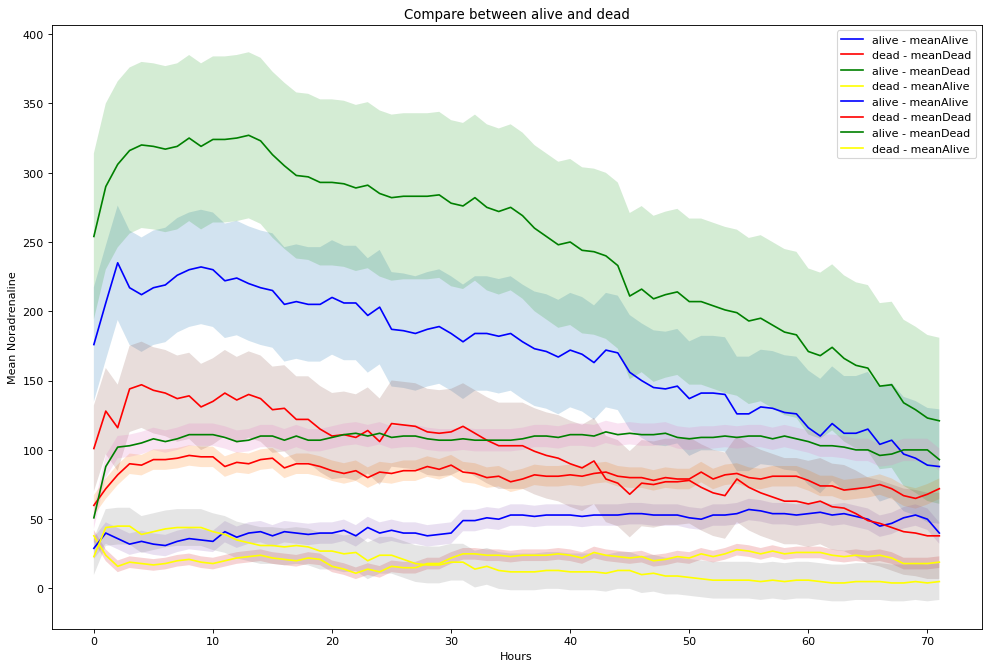

In [114]:
from matplotlib.pyplot import figure

figure(figsize=(15, 10), dpi=80)
#plot
alive = data1
alive_std = np.std(alive, axis=0)
dead = data
dead_std = np.std(dead, axis=0)
alive1 = data3
alive_std1 = np.std(alive1, axis=0)
dead1 = data2
dead_std1 = np.std(dead1, axis=0)
alive2 = data4
alive_std2 = np.std(alive2, axis=0)
dead3 = data5
dead_std3 = np.std(dead3, axis=0)
alive4 = data6
alive_std4 = np.std(alive4, axis=0)
dead5 = data7
dead_std5 = np.std(dead5, axis=0)
x = np.arange(0,72)

plt.title("Compare between alive and dead")
plt.xlabel("Hours")
plt.ylabel("Mean Noradrenaline")
plt.plot(x, alive, color ="blue", label = "alive - meanAlive")
plt.fill_between(x,np.subtract(alive, alive_std), np.add(alive, alive_std), alpha=.2)
plt.plot(x, dead, color ="red", label = "dead - meanDead")
plt.fill_between(x,np.subtract(dead, dead_std), np.add(dead, dead_std), alpha=.2)
plt.plot(x, alive1, color ="green", label = "alive - meanDead")
plt.fill_between(x,np.subtract(alive1, alive_std1), np.add(alive1, alive_std1), alpha=.2)
plt.plot(x, dead1, color ="yellow", label = "dead - meanAlive")
plt.fill_between(x,np.subtract(dead1, dead_std1), np.add(dead1, dead_std1), alpha=.2)
plt.plot(x, alive2, color ="blue", label = "alive - meanAlive")
plt.fill_between(x,np.subtract(alive2, alive_std2), np.add(alive2, alive_std2), alpha=.2)
plt.plot(x, dead3, color ="red", label = "dead - meanDead")
plt.fill_between(x,np.subtract(dead3, dead_std3), np.add(dead3, dead_std3), alpha=.2)
plt.plot(x, alive4, color ="green", label = "alive - meanDead")
plt.fill_between(x,np.subtract(alive4, alive_std4), np.add(alive4, alive_std4), alpha=.2)
plt.plot(x, dead5, color ="yellow", label = "dead - meanAlive")
plt.fill_between(x,np.subtract(dead5, dead_std5), np.add(dead5, dead_std5), alpha=.2)
plt.legend()
plt.show()

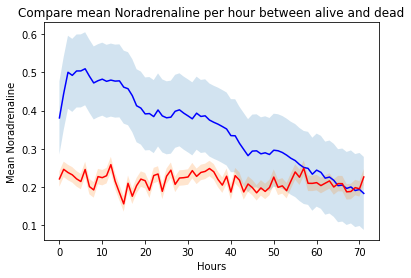

In [65]:
#plot
alive = data1
alive_std = np.std(alive, axis=0)
dead = data
dead_std = np.std(dead, axis=0)
x = np.arange(0,72)

plt.title("Compare mean Noradrenaline per hour between alive and dead")
plt.xlabel("Hours")
plt.ylabel("Mean Noradrenaline")
plt.plot(x, alive, color ="blue")
plt.fill_between(x,np.subtract(alive, alive_std), np.add(alive, alive_std), alpha=.2)
plt.plot(x, dead, color ="red")
plt.fill_between(x,np.subtract(dead, dead_std), np.add(dead, dead_std), alpha=.2)

plt.show()

In [10]:
#function to compare amount of peoplt to the mean nore
def compare_to_mean(h, ICU):
    hourH = merged_df[merged_df.hour_counter==h]
    allAlive = hourH[hourH['ICU_mortality'] == 0]
    aliveMeanNor = allAlive["Noradrenaline (Norepinephrine)"].mean()
    cg = 0
    c = 0
    for index, row in hourH.iterrows():
        if (row['Noradrenaline (Norepinephrine)']<aliveMeanNor):
            cg = cg+1
            if(row['ICU_mortality']==ICU):
                c = c+1
    print(aliveMeanNor)
    print(cg, c)

compare_to_mean(15, 1)

0.625751104651163
282 67


In [11]:
#create table of the patients with LOS=3 or LOS=4
LOS_3_4 = merged_df[(merged_df.ICU_LOS==3) | (merged_df.ICU_LOS==4)]
LOS_3_4.head()

,patient_id,hour_counter,Noradrenaline (Norepinephrine),Vasopressin=Argipressin,Adrenalin (Epinephrine),Dobutrex (Dobutamine),Dopamine,ICU_LOS,LOS_Group,ICU_mortality
91,00DC5986-2240-45A4-85E6-1619E2959E25,0,0.7989,0.00000,0.0,0.0,0.0,3,LOS_3-4,0
92,00DC5986-2240-45A4-85E6-1619E2959E25,1,1.2278,0.56667,0.0,0.0,0.0,3,LOS_3-4,0
93,00DC5986-2240-45A4-85E6-1619E2959E25,2,1.4820,2.48333,0.0,0.0,0.0,3,LOS_3-4,0
94,00DC5986-2240-45A4-85E6-1619E2959E25,3,1.4820,3.40076,0.0,0.0,0.0,3,LOS_3-4,0
95,00DC5986-2240-45A4-85E6-1619E2959E25,4,1.4820,4.00190,0.0,0.0,0.0,3,LOS_3-4,0


In [12]:
#create table of the patients with LOS=5 or LOS=6
LOS_5_6 = merged_df[(merged_df.ICU_LOS==5)| (merged_df.ICU_LOS==6) | (merged_df.ICU_LOS==7)]
LOS_5_6.head()

,patient_id,hour_counter,Noradrenaline (Norepinephrine),Vasopressin=Argipressin,Adrenalin (Epinephrine),Dobutrex (Dobutamine),Dopamine,ICU_LOS,LOS_Group,ICU_mortality
37,0090EDD0-704B-4AF4-B18D-90A06A5C6514,1,0.40037,0.0,0.0,0.0,0.0,6,LOS_5-7,0
38,0090EDD0-704B-4AF4-B18D-90A06A5C6514,2,0.37020,0.0,0.0,0.0,0.0,6,LOS_5-7,0
39,0090EDD0-704B-4AF4-B18D-90A06A5C6514,3,0.34560,0.0,0.0,0.0,0.0,6,LOS_5-7,0
40,0090EDD0-704B-4AF4-B18D-90A06A5C6514,4,0.29640,0.0,0.0,0.0,0.0,6,LOS_5-7,0
41,0090EDD0-704B-4AF4-B18D-90A06A5C6514,5,0.26196,0.0,0.0,0.0,0.0,6,LOS_5-7,0


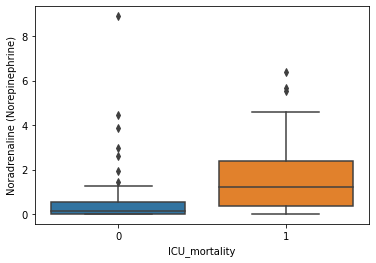

In [13]:
#function to present a boxplot with a comparison between the amount of Noradrenaline that 
#were given to people who died eventually to those who survived in specific hour.
def create_df(x):
    df = LOS_3_4[LOS_3_4.hour_counter==x]
    sns.boxplot(x = 'ICU_mortality', y = 'Noradrenaline (Norepinephrine)', data = df)
create_df(48)

In [14]:
#Function to get a list of mean Noradrenaline per hour in which group (alive or dead) from those who
#where had LOS=3 or LOS=4
def create_mean_graph_LOS_3_4(ICU):
    df = LOS_3_4[LOS_3_4.ICU_mortality==ICU]
    data = []
    for i in range(0,48):
        hourI = df[df.hour_counter==i]
        data.append(hourI['Noradrenaline (Norepinephrine)'].mean())
    #print(data)
    return data

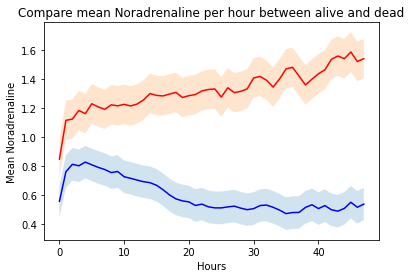

In [15]:
#plot
alive = create_mean_graph_LOS_3_4(0)
alive_std = np.std(alive, axis=0)
dead = create_mean_graph_LOS_3_4(1)
dead_std = np.std(dead, axis=0)
x = np.arange(0,48)

plt.title("Compare mean Noradrenaline per hour between alive and dead")
plt.xlabel("Hours")
plt.ylabel("Mean Noradrenaline")
plt.plot(x, alive, color ="blue")
plt.fill_between(x,np.subtract(alive, alive_std), np.add(alive, alive_std), alpha=.2)
plt.plot(x, dead, color ="red")
plt.fill_between(x,np.subtract(dead, dead_std), np.add(dead, dead_std), alpha=.2)

plt.show()

In [16]:
#Function to get a list of median Noradrenaline per hour in which group (alive or dead) from those who
#where had LOS=3 or LOS=4
def create_median_graph_LOS_3_4(ICU):
    df = LOS_3_4[LOS_3_4.ICU_mortality==ICU]
    data = []
    for i in range(0,48):
        hourI = df[df.hour_counter==i]
        data.append(hourI['Noradrenaline (Norepinephrine)'].median())
    #print(data)
    return data

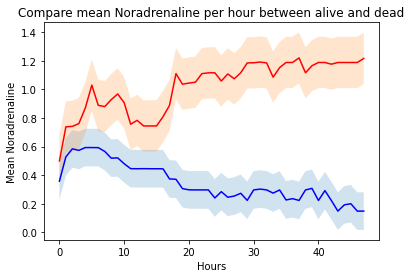

In [17]:
#plot
alive = create_median_graph_LOS_3_4(0)
alive_std = np.std(alive, axis=0)
dead = create_median_graph_LOS_3_4(1)
dead_std = np.std(dead, axis=0)
x = np.arange(0,48)

plt.title("Compare mean Noradrenaline per hour between alive and dead")
plt.xlabel("Hours")
plt.ylabel("Mean Noradrenaline")
plt.plot(x, alive, color ="blue")
plt.fill_between(x,np.subtract(alive, alive_std), np.add(alive, alive_std), alpha=.2)
plt.plot(x, dead, color ="red")
plt.fill_between(x,np.subtract(dead, dead_std), np.add(dead, dead_std), alpha=.2)

plt.show()

In [18]:
#Function to get a list of mean Noradrenaline per hour in which group (alive or dead) from all the patients
def create_mean_graph(ICU):
    df = merged_df[merged_df.ICU_mortality==ICU]
    data = []
    for i in range(0,72):
        hourI = df[df.hour_counter==i]
        data.append(hourI['Noradrenaline (Norepinephrine)'].mean())
    #print(data)
    return data

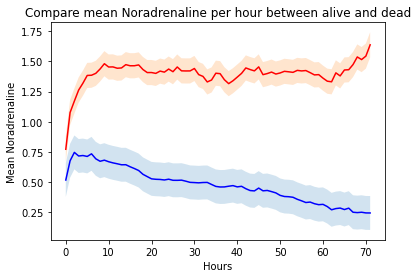

In [19]:
#plot
alive = create_mean_graph(0)
alive_std = np.std(alive, axis=0)
dead = create_mean_graph(1)
dead_std = np.std(dead, axis=0)
x = np.arange(0,72)

plt.title("Compare mean Noradrenaline per hour between alive and dead")
plt.xlabel("Hours")
plt.ylabel("Mean Noradrenaline")
plt.plot(x, alive, color ="blue")
plt.fill_between(x,np.subtract(alive, alive_std), np.add(alive, alive_std), alpha=.2)
plt.plot(x, dead, color ="red")
plt.fill_between(x,np.subtract(dead, dead_std), np.add(dead, dead_std), alpha=.2)

plt.show()

In [20]:
#Function to get a list of median Noradrenaline per hour in which group (alive or dead) from all the patients
def create_median_graph(ICU):
    df = merged_df[merged_df.ICU_mortality==ICU]
    data = []
    for i in range(0,72):
        hourI = df[df.hour_counter==i]
        data.append(hourI['Noradrenaline (Norepinephrine)'].median())
    #print(data)
    return data

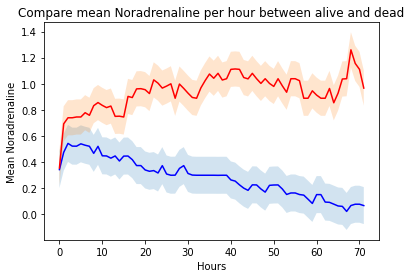

In [21]:
#plot
alive = create_median_graph(0)
alive_std = np.std(alive, axis=0)
dead = create_median_graph(1)
dead_std = np.std(dead, axis=0)
x = np.arange(0,72)

plt.title("Compare mean Noradrenaline per hour between alive and dead")
plt.xlabel("Hours")
plt.ylabel("Mean Noradrenaline")
plt.plot(x, alive, color ="blue")
plt.fill_between(x,np.subtract(alive, alive_std), np.add(alive, alive_std), alpha=.2)
plt.plot(x, dead, color ="red")
plt.fill_between(x,np.subtract(dead, dead_std), np.add(dead, dead_std), alpha=.2)

plt.show()

In [22]:
#create table without hours when the patient didn't get Noradrenaline
gotNor = merged_df[merged_df["Noradrenaline (Norepinephrine)"]>0]
gotNor.head()

,patient_id,hour_counter,Noradrenaline (Norepinephrine),Vasopressin=Argipressin,Adrenalin (Epinephrine),Dobutrex (Dobutamine),Dopamine,ICU_LOS,LOS_Group,ICU_mortality
37,0090EDD0-704B-4AF4-B18D-90A06A5C6514,1,0.40037,0.0,0.0,0.0,0.0,6,LOS_5-7,0
38,0090EDD0-704B-4AF4-B18D-90A06A5C6514,2,0.37020,0.0,0.0,0.0,0.0,6,LOS_5-7,0
39,0090EDD0-704B-4AF4-B18D-90A06A5C6514,3,0.34560,0.0,0.0,0.0,0.0,6,LOS_5-7,0
40,0090EDD0-704B-4AF4-B18D-90A06A5C6514,4,0.29640,0.0,0.0,0.0,0.0,6,LOS_5-7,0
41,0090EDD0-704B-4AF4-B18D-90A06A5C6514,5,0.26196,0.0,0.0,0.0,0.0,6,LOS_5-7,0


In [23]:
#Function to get a list of mean Noradrenaline per hour in which group (alive or dead) from all the patients (without the hours
#when the patient didn't get Noradrenaline)
def create_mean_graph_gotNor(ICU):
    df = gotNor[merged_df.ICU_mortality==ICU]
    data = []
    for i in range(0,72):
        hourI = df[df.hour_counter==i]
        data.append(hourI['Noradrenaline (Norepinephrine)'].mean())
    #print(data)
    return data

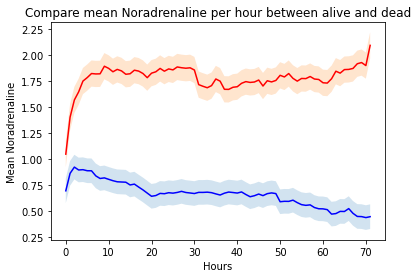

In [24]:
#plot
alive = create_mean_graph_gotNor(0)
alive_std = np.std(alive, axis=0)
dead = create_mean_graph_gotNor(1)
dead_std = np.std(dead, axis=0)
x = np.arange(0,72)

plt.title("Compare mean Noradrenaline per hour between alive and dead")
plt.xlabel("Hours")
plt.ylabel("Mean Noradrenaline")
plt.plot(x, alive, color ="blue")
plt.fill_between(x,np.subtract(alive, alive_std), np.add(alive, alive_std), alpha=.2)
plt.plot(x, dead, color ="red")
plt.fill_between(x,np.subtract(dead, dead_std), np.add(dead, dead_std), alpha=.2)

plt.show()

In [25]:
#Function to get a list of median Noradrenaline per hour in which group (alive or dead) from all the patients (without the hours
#when the patient didn't get Noradrenaline)
def create_median_graph_gotNor(ICU):
    df = gotNor[merged_df.ICU_mortality==ICU]
    data = []
    for i in range(0,72):
        hourI = df[df.hour_counter==i]
        data.append(hourI['Noradrenaline (Norepinephrine)'].median())
    #print(data)
    return data

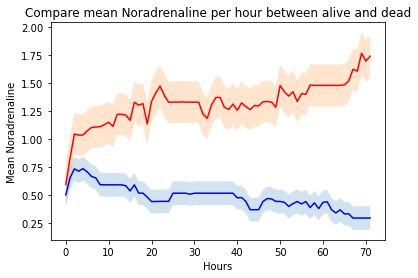

In [26]:
#plot
alive = create_median_graph_gotNor(0)
alive_std = np.std(alive, axis=0)
dead = create_median_graph_gotNor(1)
dead_std = np.std(dead, axis=0)
x = np.arange(0,72)

plt.title("Compare mean Noradrenaline per hour between alive and dead")
plt.xlabel("Hours")
plt.ylabel("Mean Noradrenaline")
plt.plot(x, alive, color ="blue")
plt.fill_between(x,np.subtract(alive, alive_std), np.add(alive, alive_std), alpha=.2)
plt.plot(x, dead, color ="red")
plt.fill_between(x,np.subtract(dead, dead_std), np.add(dead, dead_std), alpha=.2)

plt.show()

In [27]:
#devide LOS_3_4 into dead and alive, and drop column to compile the tsfresh package
alive_LOS_3_4 = LOS_3_4[LOS_3_4['ICU_mortality'] == 0]
dead_LOS_3_4 = LOS_3_4[LOS_3_4['ICU_mortality'] == 1]
dead_LOS_3_4.drop(['ICU_mortality', 'LOS_Group', 'ICU_LOS'], axis=1, inplace=True)
alive_LOS_3_4.drop(['ICU_mortality', 'LOS_Group', 'ICU_LOS'], axis=1, inplace=True)

In [28]:
#use extract_features for dead
extracted_features_dead = extract_features(dead_LOS_3_4, column_id = "patient_id")

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 20/20 [00:29<00:00,  1.47s/it]


In [29]:
#use extract_features for alive
extracted_features_alive = extract_features(alive_LOS_3_4, column_id = "patient_id")

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 20/20 [00:43<00:00,  2.18s/it]


In [30]:
dead_ppl = impute(extracted_features_dead)

In [31]:
alive_ppl = impute(extracted_features_alive)

In [32]:
# create table with the only columns we want to identify
alive_ppl_specific_columns = alive_ppl[['Noradrenaline (Norepinephrine)__matrix_profile__feature_"min"__threshold_0.98',
   'Noradrenaline (Norepinephrine)__matrix_profile__feature_"max"__threshold_0.98',
   'Noradrenaline (Norepinephrine)__matrix_profile__feature_"mean"__threshold_0.98',
   'Noradrenaline (Norepinephrine)__matrix_profile__feature_"median"__threshold_0.98',
   'Noradrenaline (Norepinephrine)__matrix_profile__feature_"25"__threshold_0.98',
   'Noradrenaline (Norepinephrine)__matrix_profile__feature_"75"__threshold_0.98']]
dead_ppl_specific_columns = dead_ppl[['Noradrenaline (Norepinephrine)__matrix_profile__feature_"min"__threshold_0.98',
   'Noradrenaline (Norepinephrine)__matrix_profile__feature_"max"__threshold_0.98',
   'Noradrenaline (Norepinephrine)__matrix_profile__feature_"mean"__threshold_0.98',
   'Noradrenaline (Norepinephrine)__matrix_profile__feature_"median"__threshold_0.98',
   'Noradrenaline (Norepinephrine)__matrix_profile__feature_"25"__threshold_0.98',
   'Noradrenaline (Norepinephrine)__matrix_profile__feature_"75"__threshold_0.98']]

In [33]:
#find the 10 colomns with the biggest diffrent between the mean of the dead to the mean of the alive
diff_between_aliev_and_dead = []
i=0
for column in alive_ppl:
    diff_between_aliev_and_dead.append([alive_ppl.columns[i], alive_ppl[column].mean()-dead_ppl[column].mean()])
    i=i+1
sorted(diff_between_aliev_and_dead, key=lambda t: t[1], reverse=True)[:10]

[['Dopamine__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC"',
  332085232544579.0],
 ['Vasopressin=Argipressin__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC"',
  248624887010307.9],
 ['hour_counter__ar_coefficient__coeff_9__k_10', 77708178.77414003],
 ['Adrenalin (Epinephrine)__ar_coefficient__coeff_6__k_10', 6521866.532043072],
 ['hour_counter__ar_coefficient__coeff_7__k_10', 426967.77260684245],
 ['Vasopressin=Argipressin__ar_coefficient__coeff_9__k_10', 116376.4716733009],
 ['Dopamine__ar_coefficient__coeff_8__k_10', 8884.94548084347],
 ['Adrenalin (Epinephrine)__ar_coefficient__coeff_4__k_10', 7754.890628817613],
 ['Vasopressin=Argipressin__ar_coefficient__coeff_7__k_10',
  2740.0819892885243],
 ['hour_counter__ar_coefficient__coeff_5__k_10', 2304.2942119185436]]